In [17]:
import sys
import pickle
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib
import itertools
import time
import random
from IPython.display import clear_output, display

import multiprocessing as mp
from functools import partial

sns.set(color_codes=True)
pd.set_option('display.max_colwidth', 1000)

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (15, 10)

### Load precomputed features

In [4]:
data_dir = '/home/guyos/Documents/bus_detection/50_50/'
# data_dir = '/home/guyos/D/Public/Kirill/'
with open(data_dir + 'ftrs.pickle', 'rb') as handle:
    X, y = pickle.load(handle)

del X['Rating']
print(len(X))
print(np.bincount(y))
# list(X.columns)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=223, stratify=y)

# 2035
# [1502  533]

2035
[1604  431]


### Поиск по сетке с нативным xgb.cv методом

In [5]:
def xgb_grid_search(model, X, y, cv_grid, eval_metric='rmse', nfold=5,
                    early_stopping_rounds=None, updater=None, max_bin=None):
    def dict_product(dicts):
        return (dict(zip(dicts, x)) for x in itertools.product(*dicts.values()))

    g = dict_product(cv_grid)
    params_list = list(g)

    tmp = time.time()
    
    keeper = []
    for i, params in enumerate(params_list):
        model.set_params(**params)
        booster_params = model.get_params()
        if updater:
            booster_params['updater'] = updater
        booster_params['nthread'] = mp.cpu_count()
        if max_bin:
            booster_params['max_bin'] = max_bin
        res = cross_validate(booster_params, X, y, nfold, eval_metric,
                             early_stopping_rounds=early_stopping_rounds)

        last = res.iloc[-1].copy()
        last['params'] = params
        last['perc'] = int(100 * i / len(params_list))
        last = pd.DataFrame(last).T
        
        keeper.append(last)
        clear_output(wait=True)
        display(last)

    search_time = time.time() - tmp
    print('search_time %s' % search_time)

    result = pd.concat(keeper)
    result.reset_index(inplace=True, drop=True)
    
    return result


def cross_validate(params, X, y, nfold, eval_metric,
                   early_stopping_rounds=None):
    dtrain = xgb.DMatrix(X, y)
    if 'n_estimators' in params:
        num_boost_round = params['n_estimators']
    else:
        num_boost_round = 100  # default number in XGBClassifier

    res = xgb.cv(params, dtrain, nfold=nfold, num_boost_round=num_boost_round,
                 metrics=[eval_metric], seed=0, as_pandas=True, #stratified=True
                 early_stopping_rounds=early_stopping_rounds)
    return res

In [6]:
def evaluate(probs, y_test, threshold=0.5):
    y_pred = (probs >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred) * 100
    f1score = f1_score(y_test, y_pred) * 100
    if len(np.unique(y_test)) != 1:
        auc = roc_auc_score(y_test, probs) * 100
    else:
        auc = 0
    print("Accuracy: %.2f%%, f1 score: %.2f%%, auc score: %.2f%%" % (accuracy, f1score, auc))

    cm = confusion_matrix(y_test, y_pred)
    return cm

### Зафиксируем малый n_estimators и большой learning_rate для быстрого поиска по сетке

In [24]:
model = xgb.XGBClassifier()

cv_params = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'max_depth': [3,4,5,6],
    'min_child_weight': [1,2,3,4,5],
    'gamma': [1,2,3,4,5,6,7],
    'subsample':[0.8,0.9],
    'colsample_bytree':[0.8,0.9],
    'reg_alpha': [0,1,2,3,4,5],
}

res0 = xgb_grid_search(model, X_train, y_train, cv_params, nfold=5, eval_metric='auc')
res0['diff'] = res0['train-auc-mean'] - res0['test-auc-mean']

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std,params,perc
99,0.935394,0.0127843,0.991428,0.000560354,"{'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 3}",0


KeyboardInterrupt: 

In [23]:
res0.to_csv(data_dir+'res0.csv')
res0.plot.scatter('test-auc-std', 'test-auc-mean', c='diff')

NameError: name 'res0' is not defined

### choose params with best bias/variance tradeoff

In [22]:
res0[(res0['test-auc-std'].between(0.00897, 0.00902))&(res0['test-auc-mean'].between(0.9367, 0.93679))]

NameError: name 'res0' is not defined

In [7]:
best_params = {'n_estimators': 100, 'learning_rate': 0.1, 
               'max_depth': 5, 'min_child_weight': 1, 
               'gamma': 3, 'subsample': 0.8, 
               'colsample_bytree': 0.8, 'reg_alpha': 5}

In [21]:
res0['diff'] = res0['train-auc-mean'] - res0['test-auc-mean']

# can't overfitt more than 5 %
# sub = res0[res0['diff'] <= 0.06].copy()
sub = res0

sub.sort_values(by=['test-auc-mean'], inplace=True, ascending=[False])
best = sub.iloc[0]
# best_params = best['params']
display(best)

NameError: name 'res0' is not defined

### Finetune n_estimators with early stopping

In [8]:
model = xgb.XGBClassifier()
model.set_params(**best_params)

estop = 40
dtrain = xgb.DMatrix(X_train, y_train)
res3 = xgb.cv(model.get_params(), dtrain, metrics=['auc'],
             num_boost_round=10000, nfold=5,
             early_stopping_rounds=estop, 
              seed=0, stratified=True,
             verbose_eval=True)

best_nrounds = res3.shape[0] - estop
best_nrounds = int(best_nrounds / 0.8)

[0]	train-auc:0.884464+0.00532759	test-auc:0.853798+0.0213095
[1]	train-auc:0.903268+0.00695158	test-auc:0.876955+0.0245069
[2]	train-auc:0.914573+0.00748724	test-auc:0.890663+0.0185968
[3]	train-auc:0.924679+0.0045407	test-auc:0.899946+0.0149099
[4]	train-auc:0.930064+0.00183282	test-auc:0.901839+0.0120465
[5]	train-auc:0.935651+0.00343139	test-auc:0.905137+0.0141309
[6]	train-auc:0.937562+0.00413267	test-auc:0.906418+0.014609
[7]	train-auc:0.941496+0.00438461	test-auc:0.908103+0.0138871
[8]	train-auc:0.945053+0.00290783	test-auc:0.910172+0.0121581
[9]	train-auc:0.947048+0.0023111	test-auc:0.909099+0.0116221
[10]	train-auc:0.947985+0.00294232	test-auc:0.908727+0.0105856
[11]	train-auc:0.950635+0.00252055	test-auc:0.913298+0.0122338
[12]	train-auc:0.952095+0.00248408	test-auc:0.914533+0.0107853
[13]	train-auc:0.952598+0.00270534	test-auc:0.916544+0.00993282
[14]	train-auc:0.953899+0.00258665	test-auc:0.9189+0.00936226
[15]	train-auc:0.95589+0.0020318	test-auc:0.920605+0.00785748
[16]	t

[131]	train-auc:0.979622+0.00199686	test-auc:0.937311+0.0110248
[132]	train-auc:0.979622+0.00199686	test-auc:0.937311+0.0110248
[133]	train-auc:0.979796+0.0020508	test-auc:0.9373+0.01104
[134]	train-auc:0.979796+0.0020508	test-auc:0.9373+0.01104
[135]	train-auc:0.979796+0.0020508	test-auc:0.9373+0.01104
[136]	train-auc:0.979796+0.0020508	test-auc:0.9373+0.01104
[137]	train-auc:0.979924+0.00209208	test-auc:0.937481+0.0109389
[138]	train-auc:0.979924+0.00209208	test-auc:0.937481+0.0109389
[139]	train-auc:0.979924+0.00209208	test-auc:0.937481+0.0109389
[140]	train-auc:0.980082+0.00221004	test-auc:0.937255+0.0112238
[141]	train-auc:0.980082+0.00221004	test-auc:0.937255+0.0112238
[142]	train-auc:0.980082+0.00221004	test-auc:0.937255+0.0112238
[143]	train-auc:0.980082+0.00221004	test-auc:0.937255+0.0112238
[144]	train-auc:0.980082+0.00221004	test-auc:0.937255+0.0112238
[145]	train-auc:0.980131+0.00211895	test-auc:0.93739+0.0113688
[146]	train-auc:0.980131+0.00211895	test-auc:0.93739+0.011368

In [20]:
print(res3.iloc[-1])
print(best_nrounds)

test-auc-mean     0.937481
test-auc-std      0.010939
train-auc-mean    0.979924
train-auc-std     0.002092
Name: 137, dtype: float64
122


In [10]:
best_params['n_estimators'] = best_nrounds
best_params

{'colsample_bytree': 0.8,
 'gamma': 3,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 122,
 'reg_alpha': 5,
 'subsample': 0.8}

Accuracy: 93.12%, f1 score: 83.53%, auc score: 95.50%
[[308  13]
 [ 15  71]]
0.959501557632
0.825581395349


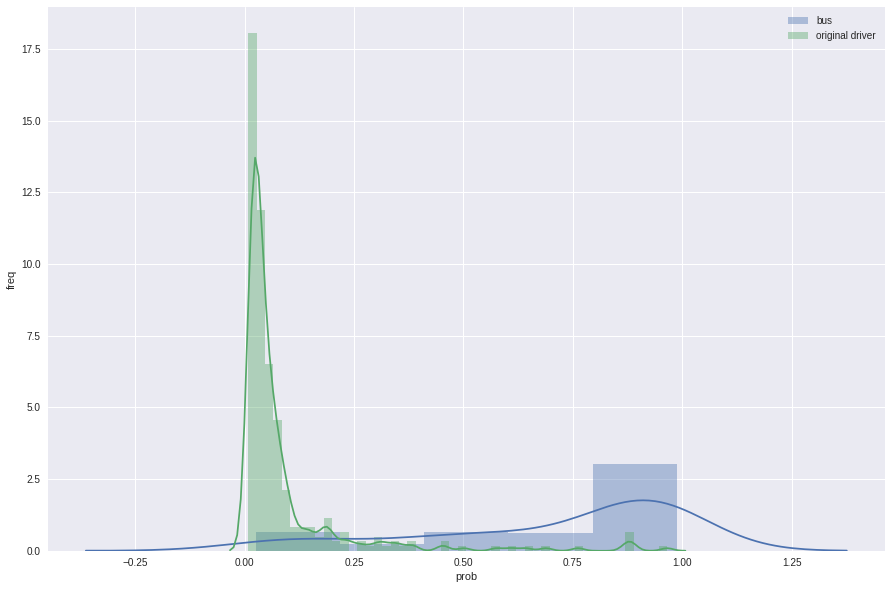

In [11]:
model = xgb.XGBClassifier()
model.set_params(**best_params)

model.fit(X_train, y_train)

probs = model.predict_proba(X_test)[:,1]
# y_pred = (probs >= 0.5).astype(int)
# wrong_busses = X_test[(y_test == 1) & (y_pred == 0)].index
# pd.Series(wrong_busses).to_csv(data_dir + 'wrong_busses.csv', index=False)

ones = probs[np.where(y_test == 1)]
zeros = probs[np.where(y_test == 0)]

sns.distplot(ones, label='bus')
sns.distplot(zeros, label='original driver')
plt.xlabel('prob')
plt.ylabel('freq')
plt.legend(loc="best")

cm = evaluate(probs, y_test, threshold=0.4)
print(cm)
print(cm[0,0]/sum(cm[0,]))
print(cm[1,1]/sum(cm[1,]))

### save model

In [12]:
model = xgb.XGBClassifier()
model.set_params(**best_params)
model.fit(X, y)

with open(data_dir + 'model_busses.pickle', 'wb') as handle:
    pickle.dump([list(X.columns), model], handle, protocol=2)

### plot importance 

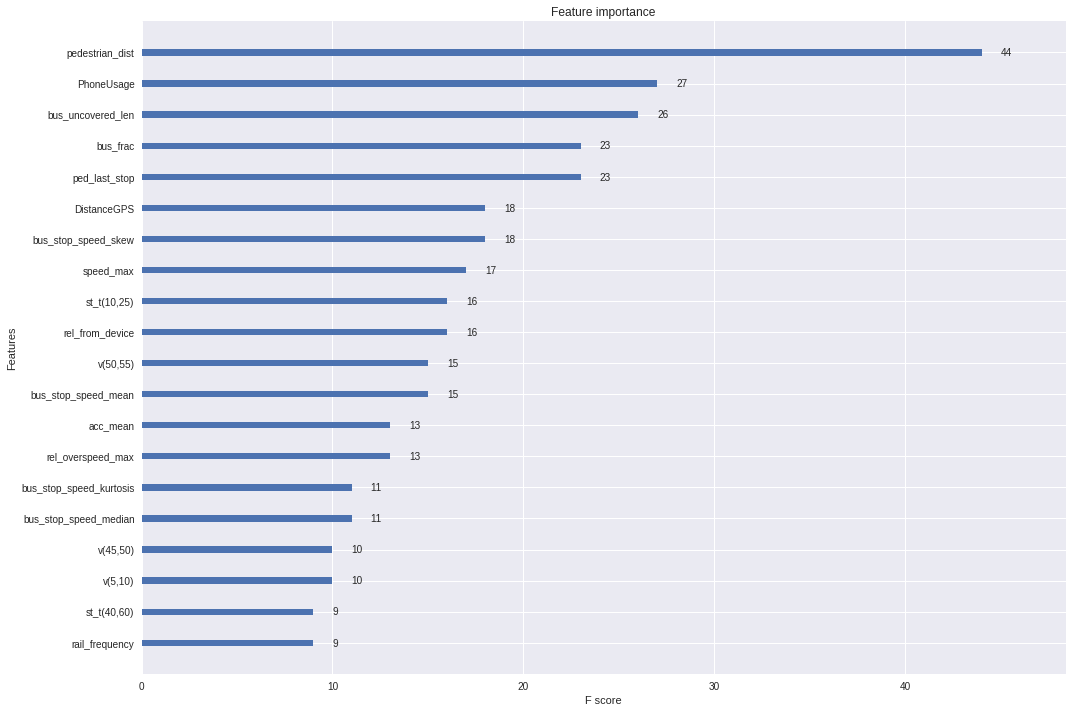

In [13]:
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plot_importance(model, max_num_features=20)
pyplot.tight_layout()
pyplot.show()

### compare with old result

In [14]:
model = xgb.XGBClassifier(colsample_bytree=0.8, gamma=5,
                             max_depth=6, n_estimators=300,
                             reg_alpha=2.5, subsample=0.9)
estop = 40
dtrain = xgb.DMatrix(X_train, y_train)
res4 = xgb.cv(model.get_params(), dtrain, metrics=['auc'],
              num_boost_round=5000, 
              nfold=5,
             early_stopping_rounds=estop, 
              seed=0, stratified=True)

best_nrounds = res3.shape[0] - estop
best_nrounds = int(best_nrounds / 0.8)
print(best_nrounds)
res4.iloc[-1]

122


test-auc-mean     0.934842
test-auc-std      0.013838
train-auc-mean    0.980074
train-auc-std     0.003520
Name: 140, dtype: float64

In [80]:
from sklearn.ensemble import RandomForestClassifier as RF

clf = RF(n_estimators=150)
# clf = clf.fit(X, y)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
scores = cross_val_score(clf, X, y, n_jobs=-1, scoring='roc_auc', cv=skf)
np.mean(scores)

0.94333546035612525

In [81]:
model = RF(n_estimators=150)
model.fit(X_train, y_train)
train_probs = model.predict_proba(X_train)[:,1]
print(roc_auc_score(y_train, train_probs))

test_probs = model.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, test_probs))

1.0
0.930698961047


In [18]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/home/guyos/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

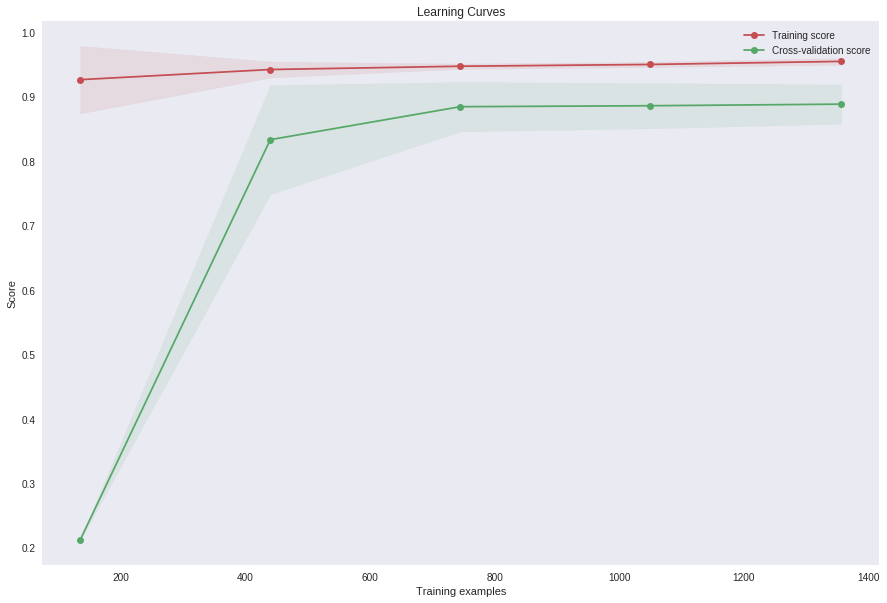

In [19]:
plot_learning_curve(model, 'Learning Curves', X, y, n_jobs=-1)